# Autoregressive Integrated Moving Average (ARIMA) --- recursive one-step
---

## COVID-19 Canada Forecast of Cases and Deaths

- Daily forecast (in figure): predicting daily numbers (the following 28 daily numbers)

- Weekly forecast (in figure): predicting weekly numbers directly (the following 4 weekly numbers)

- Weekly report (in table): 4 total numbers for 4 weeks, each week is from StartDate to Date

- weekday: Mon = 1, Tue = 2, ..., Sun = 7


Data source: [OxCGRT Data](https://github.com/OxCGRT/covid-policy-tracker/tree/master/data)

Author: Jianfei Zhang (jianfei.zhang@ualberta.ca)

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
from matplotlib import pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=300
from datetime import datetime, timedelta
from statsmodels.tsa.arima.model import ARIMA

In [2]:
def load_OxCGRT():
    path = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker/master/data/OxCGRT_latest.csv'
    d = pd.read_csv(path, parse_dates=['Date'], low_memory=False)
    d[['CountryName', 'RegionCode']] = d[['CountryName', 'RegionCode']].fillna('')
    d['Cases'], d['Deaths'] = d.ConfirmedCases.fillna(0), d.ConfirmedDeaths.fillna(0)
    d['Date'] = pd.to_datetime(d['Date'], format='%m/%d/%y')
    return d

def get_df(d, CountryName, RegionCode = ''):
    d = d[(d['CountryName'] == CountryName) & (d['RegionCode'] == RegionCode)].copy()
    # get weekday column, weekday: Mon=1, Tue=2, ...., Sun=7
    d["weekday"] = d['Date'].dt.dayofweek + 1
    d = d.set_index(['CountryName', 'RegionCode', 'weekday', 'Date'])
    return d

In [3]:
d = load_OxCGRT()
d_CA = get_df(d, 'Canada')

In [4]:
def arima_forecast(train, cfg):
    model = ARIMA(train, order = (cfg[0], cfg[1], cfg[2]))
    model_fit = model.fit()
    yhat = model_fit.forecast()[0]
    return yhat

## Daily Forecast

In [11]:
def daily_report(df, target_, predictions_, end_weekday, pred_steps):
    date_col, weekday = 'Date', 'weekday'
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta(i+1) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target_: predictions_}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col, weekday])
    df_merge = df[[target_]].join(df_forecast[['Predicted'+target_]], how='outer')
    df_merge.index = df_merge.index.droplevel(['CountryName', 'RegionCode', 'weekday'])
    df_merge.plot(title = 'Daily New ' + target_, figsize=(8,3), lw=1, style = '.-')
    plt.show()
    df_forecast = df_forecast.cumsum()
    df_forecast = df_forecast[df_forecast.index.get_level_values(weekday) == end_weekday].fillna(0)
    first_week = df_forecast['Predicted'+target_].iloc[0]
    df_forecast = df_forecast.diff()
    df_forecast['Predicted'+target_].iloc[0] = first_week
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('Weekly New ' + target_ + ' (via Daily Prediction):\n')
    display(df_forecast.round(0).astype('int32'))

def daily_recursive_forecast(d, target, cfg, end_weekday = 5, pred_steps = 28):
    df = d[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df.diff().fillna(0)
    history = df.values
    predictions = list()
    for p in range(pred_steps):
        yhat = arima_forecast(history, cfg)
        predictions.append(yhat)
        history = np.append(history, np.array(yhat))
    daily_report(df, target[0], predictions, end_weekday, pred_steps)    

[2912.6471031669485, 2690.2581306577385, 3146.607785418125, 2856.088831532312, 2784.027601419474, 2953.4690748747826, 2900.234074766947, 2892.7396668150104, 2816.3462037131417, 2949.2949918586855, 2883.1479332939407, 2819.8720725650724, 2902.963920288573, 2878.2621861688976, 2865.8841004315937, 2846.7180784595002, 2880.630811183183, 2868.6064662591557, 2835.674911522161, 2866.8412020900237, 2859.283942247102, 2847.6654395520486, 2843.9855889447117, 2851.214117541754, 2848.5956199997318, 2833.9542109324134, 2842.9491870996935, 2840.881971818875]


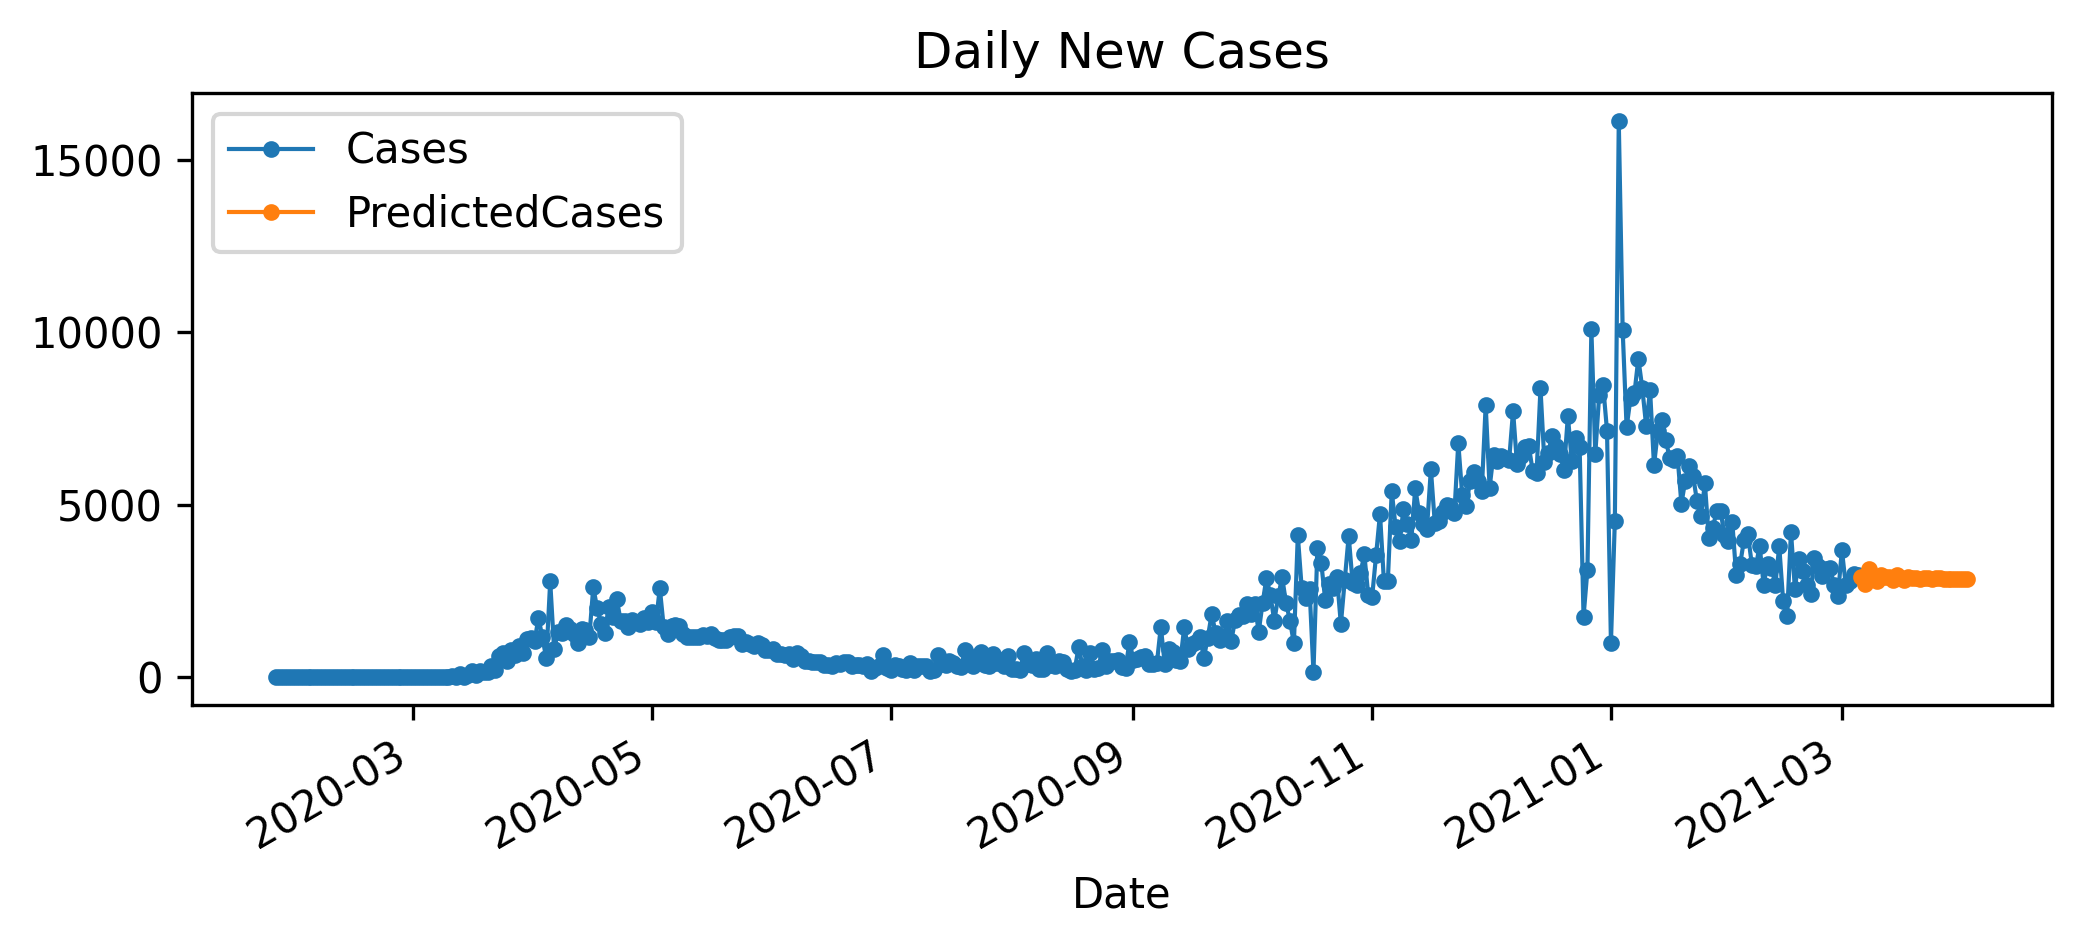

Weekly New Cases (via Daily Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,20243
2021-03-19,5,2021-03-12,20143
2021-03-26,5,2021-03-19,20024
2021-04-02,5,2021-03-26,19909


In [12]:
daily_recursive_forecast(d_CA, ['Cases'], [7, 0 ,1], 5)

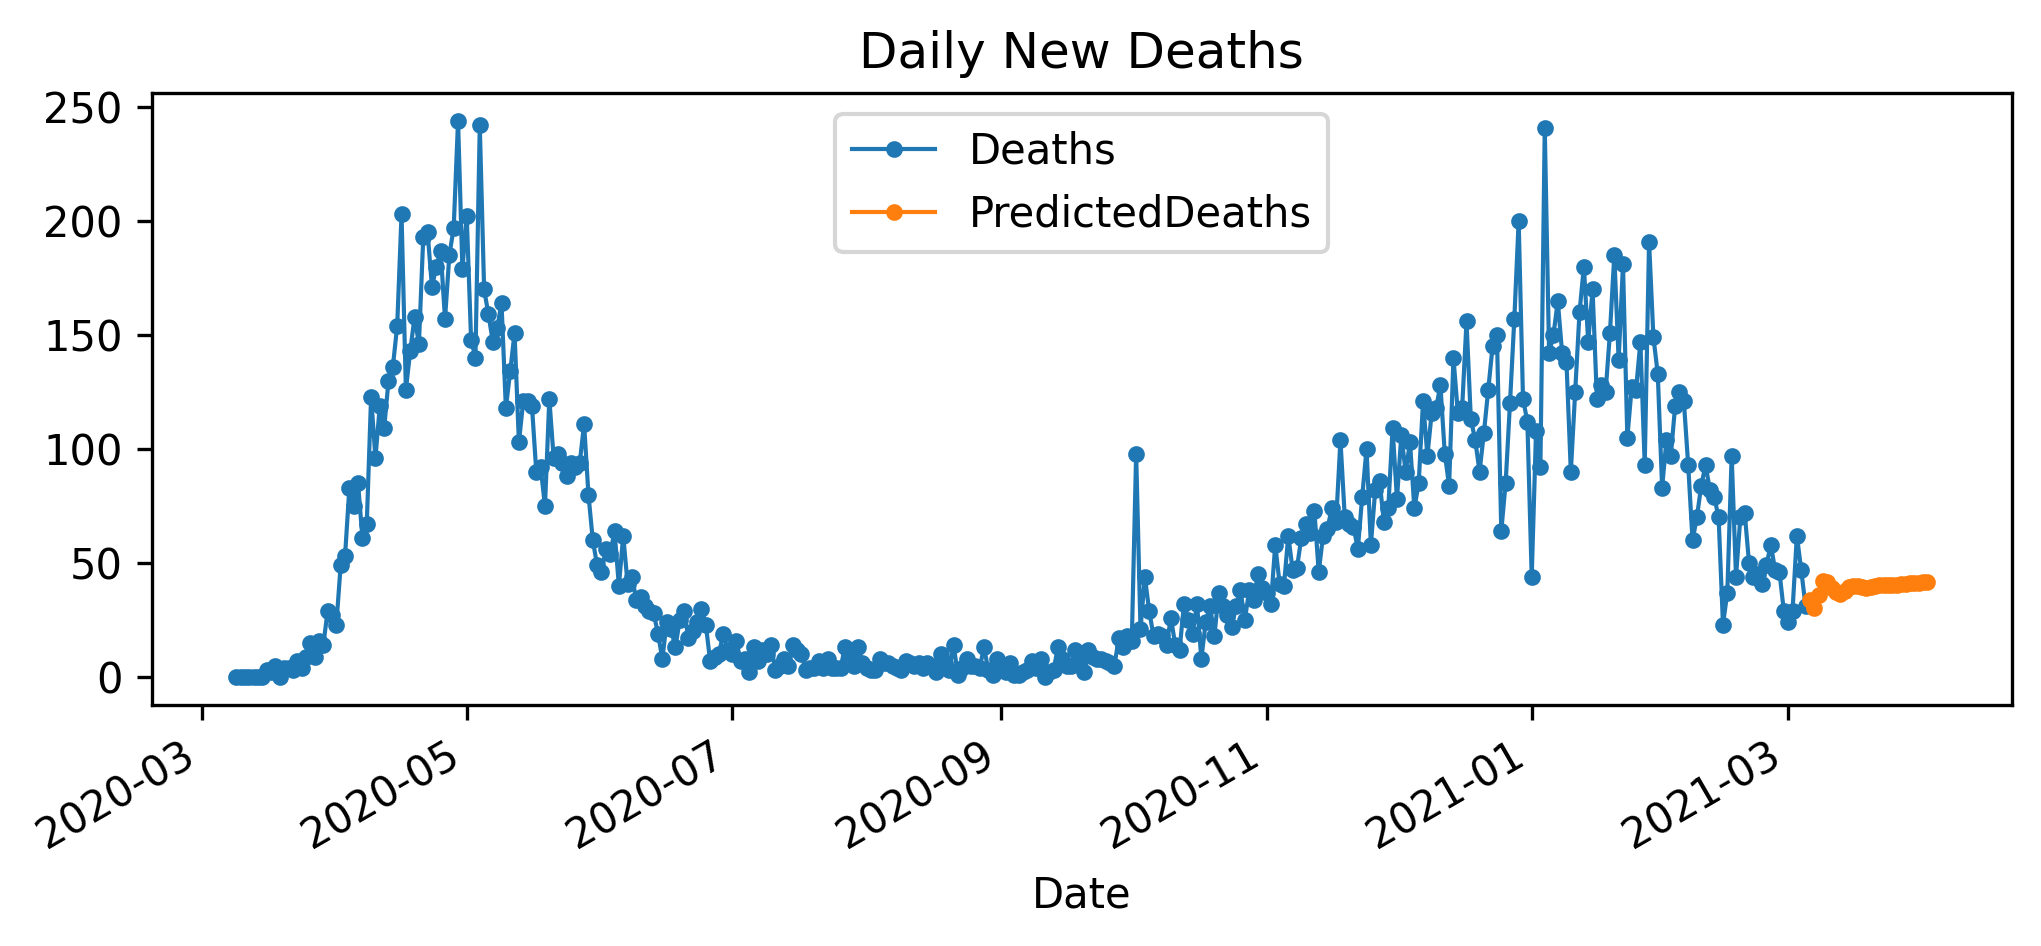

Weekly New Deaths (via Daily Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,260
2021-03-19,5,2021-03-12,272
2021-03-26,5,2021-03-19,281
2021-04-02,5,2021-03-26,288


In [7]:
daily_recursive_forecast(d_CA, ['Deaths'], [6, 0, 1], 5)

## Weekly Forecast

In [8]:
def weekly_report(df, target_, predictions_, end_weekday, pred_steps, interval):
    date_col, weekday = 'Date', 'weekday'
    pred_dates = [df.index.get_level_values(date_col).max() + timedelta((i+1)*interval) for i in range(pred_steps)]
    data_forecast = {date_col: pred_dates, 'Predicted'+target_: predictions_}
    df_forecast = pd.DataFrame(data_forecast)
    df_forecast[weekday] = df_forecast[date_col].dt.dayofweek + 1
    df_forecast = df_forecast.set_index([date_col,weekday])
    df.index = df.index.droplevel(['CountryName', 'RegionCode'])
    df_merge = df.join(df_forecast, how='outer')
    df_merge.index = df_merge.index.droplevel(['weekday'])
    df_merge.plot(title = 'Weekly New ' + target_, figsize=(8,3), lw=1, style = '.-')
    plt.show()
    df_forecast['StartDate'] = [i - np.timedelta64(7,'D') for i in df_forecast.index.get_level_values(date_col)]
    df_forecast = df_forecast.set_index('StartDate',append=True)
    df_forecast.sort_index(ascending = False)
    print('Weekly New ' + target_ + ' (via Weekly Prediction):\n')
    display(df_forecast.round(0).astype('int32'))

def weekly_recursive_forecast(d, target, cfg, end_weekday = 5, pred_steps = 4, interval = 7):
    df = d[target].copy()
    df = df.loc[df[target[0]].ne(0)]
    df = df[df.index.get_level_values('weekday') == end_weekday].fillna(0)
    df = df.diff().fillna(0)
    history = df.values
    predictions = list()
    for p in range(pred_steps):
        yhat = arima_forecast(history, cfg)
        predictions.append(yhat)
        history = np.append(history, np.array(yhat))
    weekly_report(df, target[0], predictions, end_weekday, pred_steps, interval)

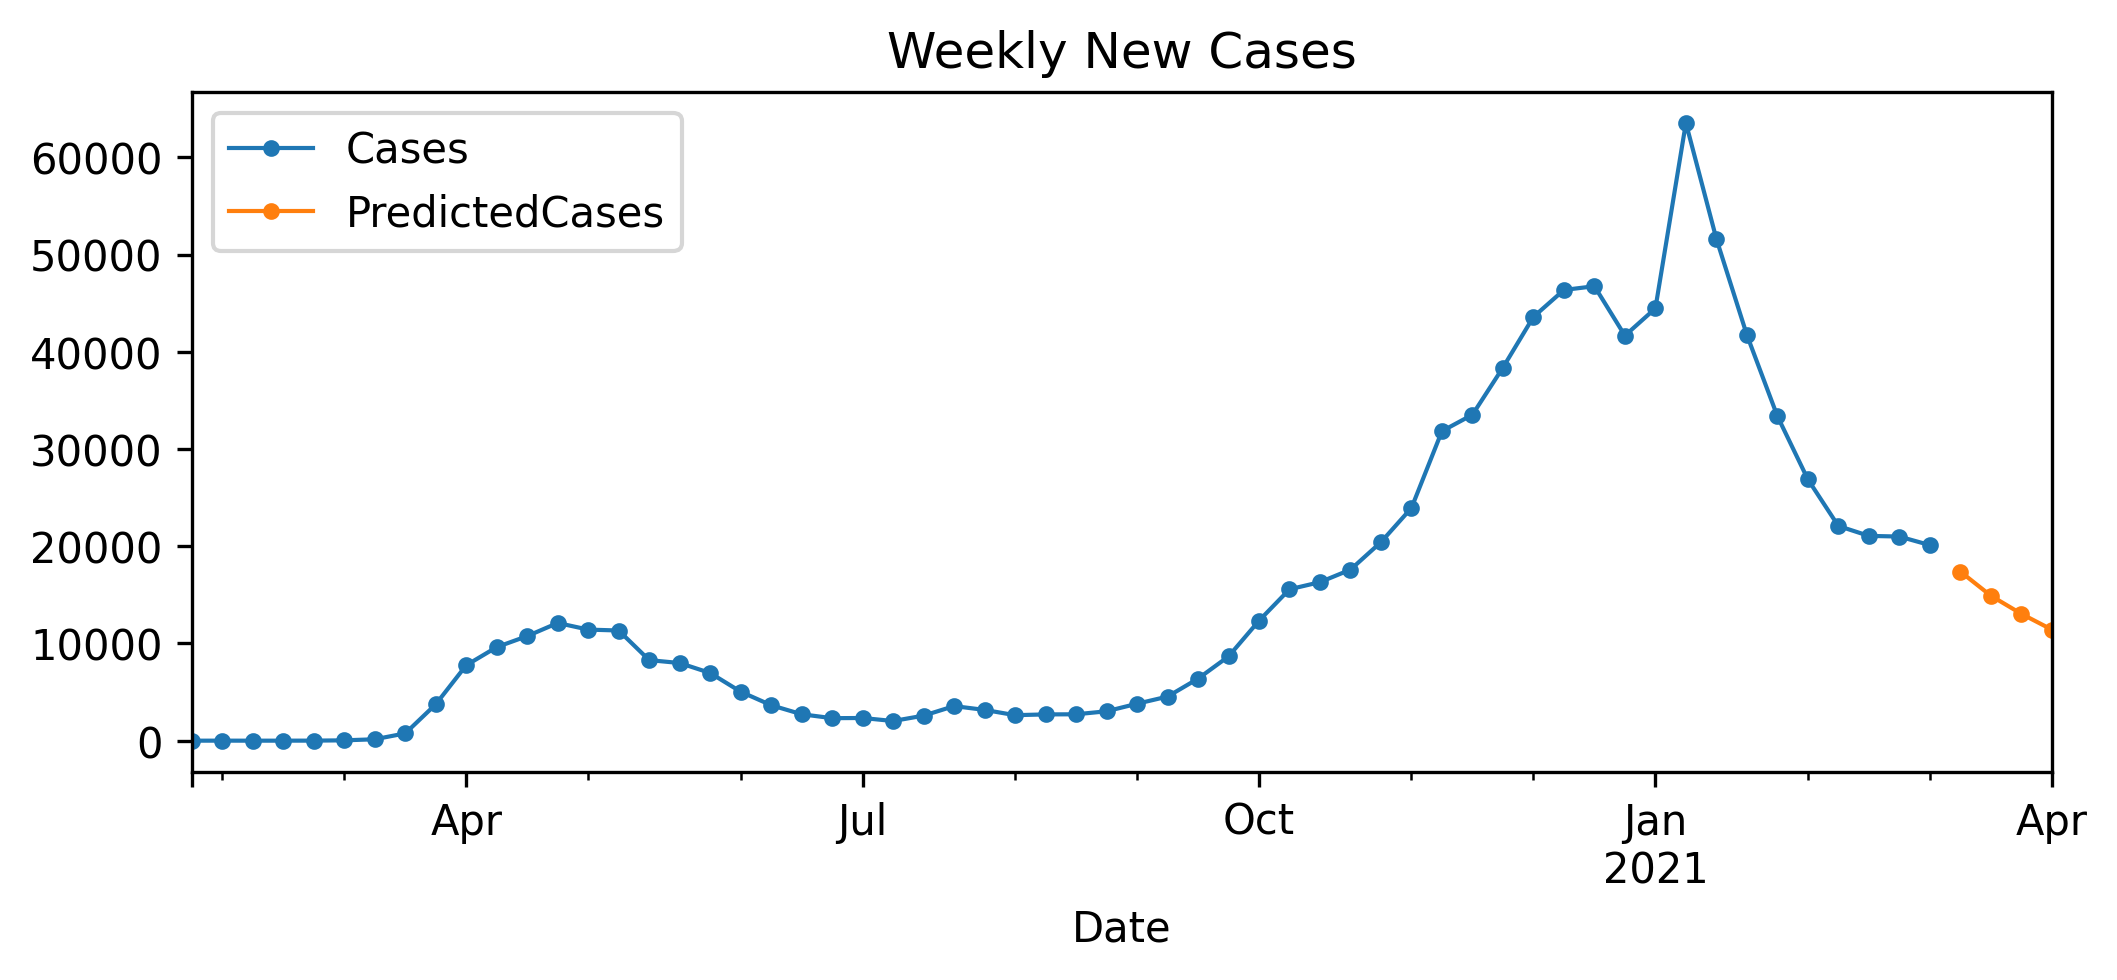

Weekly New Cases (via Weekly Prediction):



,,,PredictedCases
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,17394
2021-03-19,5,2021-03-12,14910
2021-03-26,5,2021-03-19,13048
2021-04-02,5,2021-03-26,11424


In [9]:
weekly_recursive_forecast(d_CA, ['Cases'], [4, 0, 1], 5)

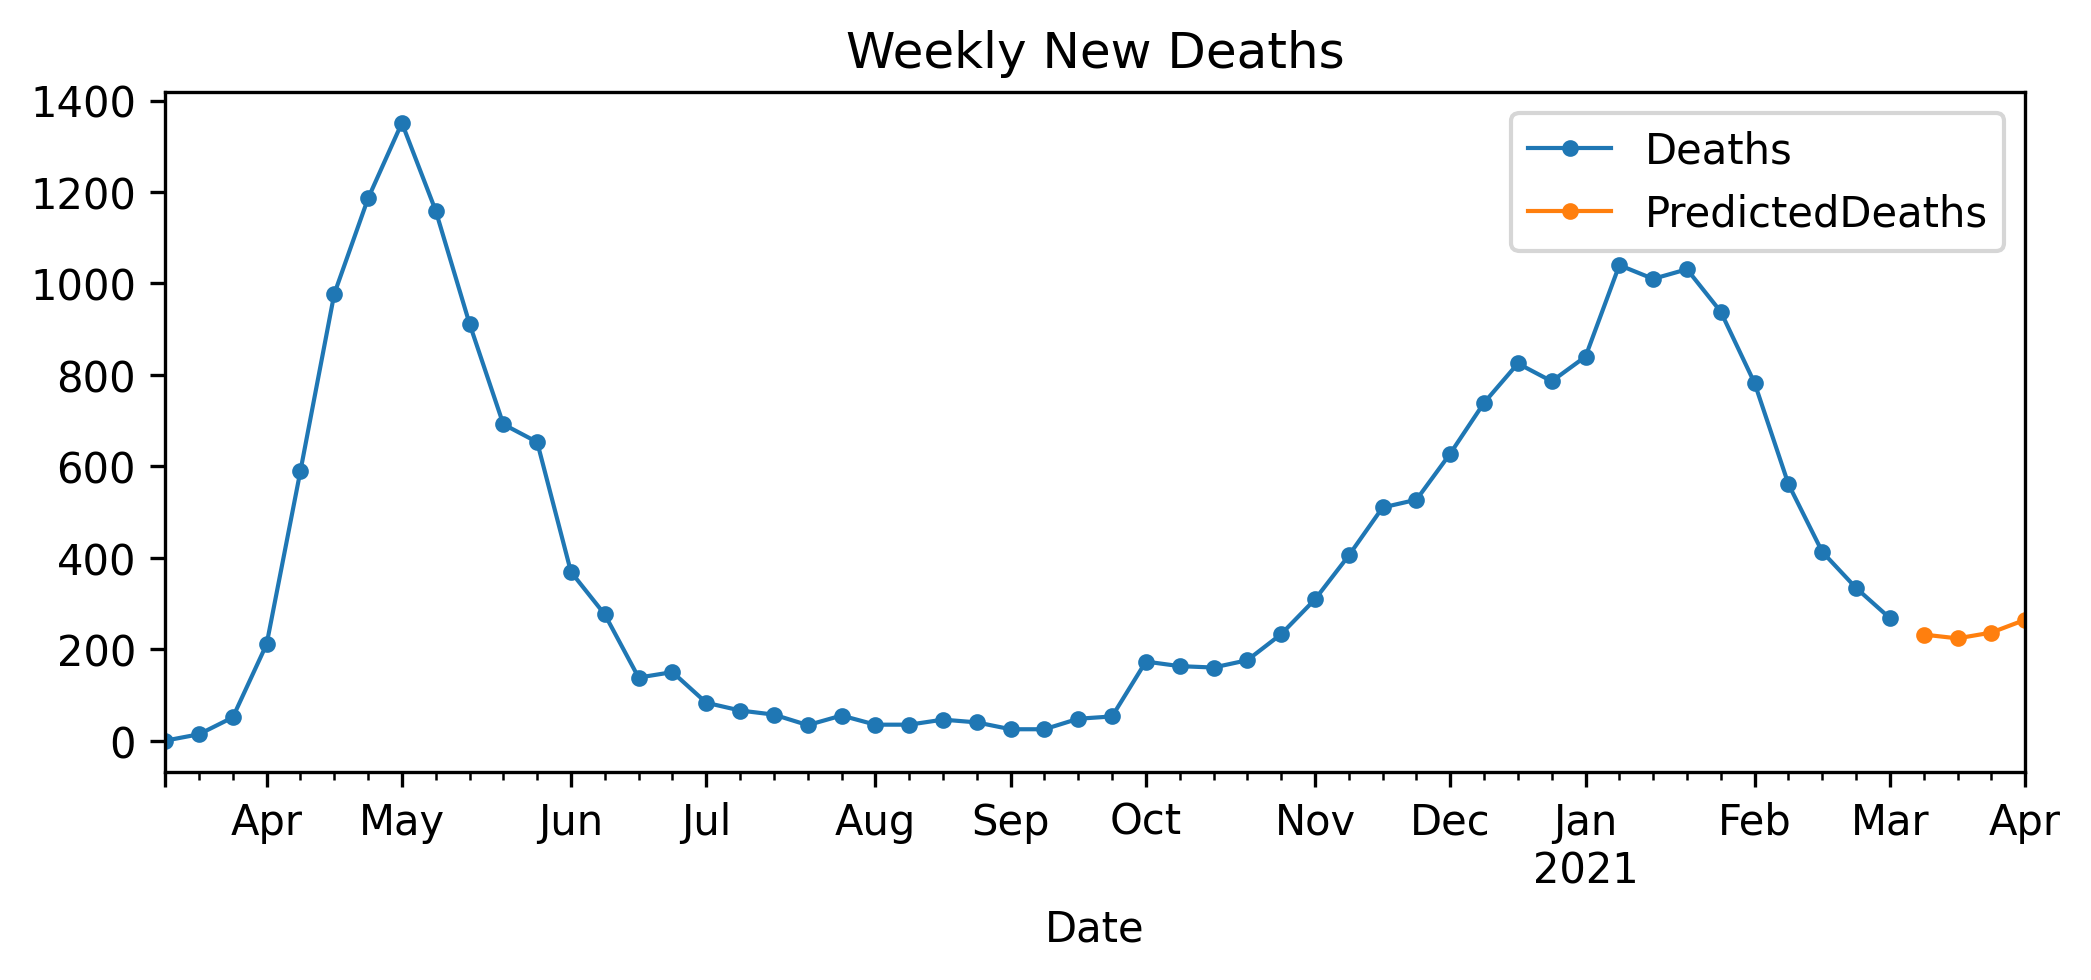

Weekly New Deaths (via Weekly Prediction):



,,,PredictedDeaths
Date,weekday,StartDate,
2021-03-12,5,2021-03-05,232
2021-03-19,5,2021-03-12,224
2021-03-26,5,2021-03-19,236
2021-04-02,5,2021-03-26,264


In [10]:
weekly_recursive_forecast(d_CA, ['Deaths'], [3, 0, 1], 5)